In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [1087]:
class TensorToPolygon:
    
    def __call__(self, data):
        data = data.view(-1, 784)
        data = list(data.unbind())
        data = [torch.arange(784)[(x > 0.8)] for x in data]
        data = [torch.Tensor(list(x) + (351 - len(x)) * [0]) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
    
class OneDToTwoD:
    
    def __call__(self, data):
        
        data = [torch.Tensor(x[x != 0]) for x in data]   
        data = [torch.Tensor([list([b // 28, b % 28]) for b in a]) for a in data]
        data = [torch.cat((x, torch.Tensor(np.zeros((351 - x.shape[0],2))))) for x in data]
        data = torch.stack(data).contiguous()
        return data
    
#class Transform1d2d:
#    def __call__(self, x):
#        return torch.stack([x // 28, x % 28], -1)
    
class Transform1d2d:
    def __call__(self, x):
        return torch.stack([((x // 28) -14) * (x != 0), ((x % 28) - 14) * (x != 0)], -1)
        

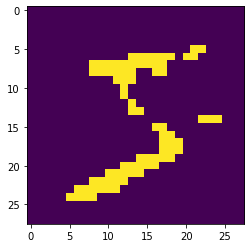

In [1098]:
def plot_preprocessing(xy):
    matrix = np.zeros(784)

    for x, y in xy[0]:
        x = x+14
        y = y+14
        #print([x, y])
        index = int(x*28+y)
        matrix[index] = 1
        
    img_size = int(math.sqrt(784))
    return np.reshape(matrix, (img_size, img_size))

plt.imshow(plot_preprocessing(default))
#print(c_mass(default)[:,0])

In [972]:
math.sqrt(784)

28.0

In [1089]:
dataset1 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset2 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=180, translate=None, scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset3 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

dataset4 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
#                              transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=0, translate=None, scale=(0.5, 1.5)),
                              transforms.ToTensor(),
                              TensorToPolygon(),
                              Transform1d2d()
                          ]))

In [1107]:
default = dataset1[0][0]
rotated = dataset2[0][0]
translated = dataset3[0][0]
scaled = dataset4[0][0]

default[:,:,0]

tensor([[-9., -9., -8., -8., -8., -8., -8., -8., -8., -8., -7., -7., -7., -7.,
         -7., -7., -7., -7., -7., -7., -6., -6., -6., -6., -6., -6., -6., -6.,
         -5., -5., -5., -4., -3., -2., -1., -1.,  0.,  0.,  0.,  1.,  1.,  2.,
          2.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
          6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  9.,
          9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         -0., -0., -0., -0., -0., -0., -0., -0., -0.

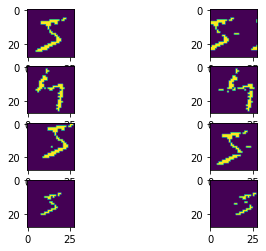

In [1241]:
figure, axis = plt.subplots(4, 2)

axis[0, 0].imshow(plot_preprocessing(default))
axis[0, 1].imshow(plot_preprocessing(canonical_transformation(default, default)))

axis[1, 0].imshow(plot_preprocessing(rotated))
axis[1, 1].imshow(plot_preprocessing(canonical_transformation(rotated, default)))

axis[2, 0].imshow(plot_preprocessing(translated))
axis[2, 1].imshow(plot_preprocessing(canonical_transformation(translated,default)))

axis[3, 0].imshow(plot_preprocessing(scaled))
axis[3, 1].imshow(plot_preprocessing(canonical_transformation(scaled, default)))

In [1180]:
def moment(xy, p, q):
    x = xy[:, :, 0]
    y = xy[:, :, 1]
    x = x.pow(p) * (x != 0)
    y = y.pow(q) * (y != 0)
    M = (x * y).sum(-1)
    return M
    

def c_mass(xy):
    mass = moment(xy, 0, 0)
    mx = moment(xy, 1, 0) / mass
    my = moment(xy, 0, 1) / mass
    return torch.stack([mx, my], -1)

def mu(xy, p, q):
    m = c_mass(xy)
    x = xy[:, :, 0]
    y = xy[:, :, 1]
    x = (x - m[:, 0]).pow(p) * (x != 0)
    y = (y - m[:, 1]).pow(q) * (y != 0)
    M = (x * y).sum(-1)
    return M

def nu(xy, p, q):
    return mu(xy, p, q) / (mu(xy,0,0)**(1 + (p+q)/2))

In [1252]:
def scale(x, p, q):
    return mu(x, p, q) / mu(x, 0, 0).pow((p+q) / 2 + 1)

def rotation(x):
    return -0.5 * torch.arctan((2*mu(x,1,1)) / (mu(x,2,0) - mu(x,0,2)))

def canonical_transformation(xy, original):
#   translation
    m = c_mass(xy)
    x = xy - m.view(1, 1, 2) * (xy[:, :, 0] != 0).view(1, -1, 1)

#   scale
    #original_nu = nu(original,2,2)
    #scale_factor = nu(xy,2,2) / original_nu
    #x = scale_factor * x
#   rotation
    return x

rotated = dataset2[0][0]
translated = dataset3[0][0]
scaled = dataset4[0][0]
print("centre_of_mass default: " + str(c_mass(default)))
print("centre_of_mass rotated: " + str(c_mass(rotated)))
print("m_10: " + str(moment(default,1,0)))
print("m_01: " + str(moment(default,0,1)))
print("m_10: " + str(moment(rotated,1,0)))
print("m_01: " + str(moment(rotated,0,1)))
print("m_20: " + str(moment(rotated,2,0)))
print("m_02: " + str(moment(rotated,0,2)))
print("Default: " + str(nu(default,2,2)))
print("Scale: " + str(nu(translated,2,2)))

#print(canonical_transformation(scaled, default))

#print(nu(default,2,0) + nu(default,0,2))
#print(nu(rotated,2,0) + nu(rotated,0,2))

#print(((nu(default,2,0) + nu(default,0,2))**2) + 4 * nu(default,1,1)**2)
#print(((nu(rotated,2,0) + nu(rotated,0,2))**2) + 4 * nu(rotated,1,1)**2)

#print(default[0][0:10])
#print(rotated[0][0:10])

centre_of_mass default: tensor([[ 0.3286, -0.7571]])
centre_of_mass rotated: tensor([[-1.3973, -1.7808]])
m_10: tensor([23.])
m_01: tensor([-53.])
m_10: tensor([-102.])
m_01: tensor([-130.])
m_20: tensor([2758.])
m_02: tensor([2310.])
Default: tensor([0.1960])
Scale: tensor([0.1861])


In [1217]:
x = dataset[0][0]
print(c_mass(x))
print(moment(x, 2, 0))
print(c_mass(canonical_transformation(x)))
print(moment(canonical_transformation(x), 0, 2))

tensor([[-1.1127, -0.5775]])
tensor([3349.])
tensor([[-0.1211,  0.0450]])
tensor([929.3248])


$$
\mathbf{M} = \frac{\sum_i \mathbf{r_i} * m_i}{\sum_i m_i}
$$

$$
\mathbf{M}' = \frac{\sum_i [\mathbf{r_i} + \pmb{\delta}] * m_i}{\sum_i m_i}
= \frac{\sum_i \mathbf{r_i}* m_i}{\sum_i m_i} + \frac{\sum_i \pmb{\delta}* m_i}{\sum_i m_i}
= \mathbf{M} + \pmb{\delta}
$$

In [129]:
m = c_mass(x)
m.shape

torch.Size([1, 2])

In [130]:
(x[:, :, 0] != 0).shape

torch.Size([1, 351])